In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = 'problem'
TRAIN_FN = 'training.csv'
TEST_FN = 'testing.csv'
SEP = '/'

## Raw Data

In [3]:
train_path = DATA_DIR + SEP + TRAIN_FN
test_path = DATA_DIR + SEP + TEST_FN
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [4]:
df_train.shape, df_test.shape

((36369, 119), (12626, 119))

In [5]:
df_train.head()

,Date,Identifier,Dep_Var,Gr1Ind_Var1,Gr1Ind_Var2,Gr1Ind_Var3,Gr1Ind_Var4,Gr1Ind_Var5,Gr1Ind_Var6,Gr1Ind_Var7,...,Gr2Ind_Var3,Gr2Ind_Var4,Gr2Ind_Var5,Gr2Ind_Var6,Gr2Ind_Var7,Gr2Ind_Var8,Gr2Ind_Var9,Gr2Ind_Var10,Gr2Ind_Var11,Gr2Ind_Var12
0,2012-10-22,1855,16,91624.526353,0.981399,-0.032599,0.030106,0.010643,0.030998,0.703471,...,0.0,0.0,0.181818,0.0,0.0,0.0,0.0,0.0,0.909091,0.165289
1,2012-10-22,9079,13,472.315066,0.980664,0.058861,-0.010248,-0.012876,-0.010084,-0.124329,...,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.750000,0.093750
2,2012-10-22,49725,16,1039.574650,0.852444,0.072414,0.011823,0.002200,0.004664,0.101501,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.600000,0.000000
3,2012-10-22,9569,9,4241.026023,1.094491,-0.015389,0.004078,0.002119,0.002838,0.079300,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.857143,0.000000
4,2012-10-22,6828,6,15404.194258,1.020933,0.009126,-0.003701,-0.003559,-0.017787,-0.335150,...,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.615385,0.047337


In [6]:
df_test.head()

,Date,Identifier,Dep_Var,Gr1Ind_Var1,Gr1Ind_Var2,Gr1Ind_Var3,Gr1Ind_Var4,Gr1Ind_Var5,Gr1Ind_Var6,Gr1Ind_Var7,...,Gr2Ind_Var3,Gr2Ind_Var4,Gr2Ind_Var5,Gr2Ind_Var6,Gr2Ind_Var7,Gr2Ind_Var8,Gr2Ind_Var9,Gr2Ind_Var10,Gr2Ind_Var11,Gr2Ind_Var12
0,2015-10-23,39380,NaN,757.138424,1.011381,-0.016461,0.016145,0.015170,0.006936,0.128563,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.857143,0.000000
1,2015-10-23,27686,NaN,176.489196,0.984577,-0.041667,-0.105687,-0.104518,-0.123699,-1.297833,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.666667,0.000000
2,2015-10-23,130,NaN,1335.001430,1.067227,-0.005897,0.014202,-0.002536,0.030125,0.445860,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.666667,0.000000
3,2015-10-23,40130,NaN,154.685706,1.002754,-0.008748,0.000927,0.000868,0.005581,0.097687,...,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.916667,0.076389
4,2015-10-23,30884,NaN,549.026934,1.079182,-0.032028,0.002453,0.002908,0.025576,0.407750,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.666667,0.000000


In [7]:
df_train.Date.min(), df_train.Date.max()

('2012-10-22', '2015-07-23')

In [8]:
df_test.Date.min(), df_test.Date.max()

('2015-10-23', '2016-07-22')

In [9]:
df_train.Identifier.nunique(), df_test.Identifier.nunique()

(3646, 3363)

In [10]:
# Add 'month' feature
df_train['month'] = pd.to_datetime(df_train.Date).dt.month
df_test['month'] = pd.to_datetime(df_test.Date).dt.month

## Create Train, Validation, and Test Sets

In [11]:
train_range = df_train.Date<'2014-07-23'
valid_range = df_train.Date>='2014-10-23'
train = df_train[train_range]
valid = df_train[valid_range]
test = df_test

In [12]:
train.shape, valid.shape, test.shape

((20963, 120), (12421, 120), (12626, 120))

In [13]:
train.isnull().mean().mean()

0.13577374421599958

In [14]:
valid.isnull().mean().mean()

0.07814252744008797

In [15]:
test.isnull().mean().mean()

0.06484700881778338

In [16]:
train.loc[:10000].isnull().mean().mean(), train.loc[10000:].isnull().mean().mean()

(0.14181498516814986, 0.13025403630393143)

In [17]:
X_train = train.drop(['Date', 'Identifier', 'Dep_Var'], axis=1)
y_train = train.Dep_Var
X_valid = valid.drop(['Date', 'Identifier', 'Dep_Var'], axis=1)
y_valid = valid.Dep_Var
X_test = test.drop(['Date', 'Identifier', 'Dep_Var'], axis=1)

X_train.head()

,Gr1Ind_Var1,Gr1Ind_Var2,Gr1Ind_Var3,Gr1Ind_Var4,Gr1Ind_Var5,Gr1Ind_Var6,Gr1Ind_Var7,Gr1Ind_Var8,Gr1Ind_Var9,Gr1Ind_Var10,...,Gr2Ind_Var4,Gr2Ind_Var5,Gr2Ind_Var6,Gr2Ind_Var7,Gr2Ind_Var8,Gr2Ind_Var9,Gr2Ind_Var10,Gr2Ind_Var11,Gr2Ind_Var12,month
0,91624.526353,0.981399,-0.032599,0.030106,0.010643,0.030998,0.703471,0.010389,0.027373,0.001259,...,0.0,0.181818,0.0,0.0,0.0,0.0,0.0,0.909091,0.165289,10
1,472.315066,0.980664,0.058861,-0.010248,-0.012876,-0.010084,-0.124329,-0.010085,9.748330,0.292432,...,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.750000,0.093750,10
2,1039.574650,0.852444,0.072414,0.011823,0.002200,0.004664,0.101501,0.002900,-5.534298,0.070029,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.600000,0.000000,10
3,4241.026023,1.094491,-0.015389,0.004078,0.002119,0.002838,0.079300,0.001504,-1.529305,0.051030,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.857143,0.000000,10
4,15404.194258,1.020933,0.009126,-0.003701,-0.003559,-0.017787,-0.335150,-0.017833,-0.802841,-0.065432,...,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.615385,0.047337,10


## Transform Dep_Var

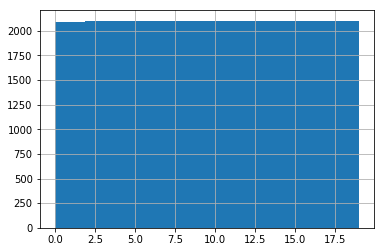

In [18]:
y_train.hist()
plt.show()

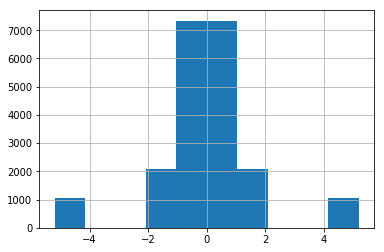

In [19]:
q = QuantileTransformer(output_distribution='normal')
y_train_gauss = pd.Series( q.fit_transform(y_train.values.reshape(-1, 1)).reshape(-1))
y_train_gauss.hist()
plt.show()

In [20]:
check = q.inverse_transform(y_train_gauss.values.reshape(-1, 1)).reshape(-1)
pd.DataFrame({'raw':y_train, 'check':check, 'gauss':y_train_gauss}).head()

,raw,check,gauss
0,16,16.0,0.933910
1,13,13.0,0.454249
2,16,16.0,0.933910
3,9,9.0,-0.062770
4,6,6.0,-0.454249


In [21]:
np.allclose(check, y_train)

True

## Fit GBM Model to Training Subset and Predict Validation Set

In [22]:
X = X_train.astype(np.float32)

In [23]:
d_train = lgb.Dataset(X, label=y_train_gauss)
params = {}
params['learning_rate'] = 0.004 # 0.004 # shrinkage_rate
params['sub_feature'] = 0.35    # feature_fraction (small values => use very different submodels)
params['min_data'] = 500        # min_data_in_leaf
params['max_depth'] = 2

nboost=130

reg = lgb.train(params, d_train, nboost)
pred = reg.predict(X_valid)

n_minus = 30
params['max_depth'] = 3
reg = lgb.train(params, d_train, nboost-n_minus)
alpha = 0.5
pred = alpha*pred + (1-alpha)*reg.predict(X_valid)

n_plus = 40
params['max_depth'] = 2
params['bagging_freq'] = 5
params['bagging_fraction'] = 0.78
params['learning_rate'] = .005
reg = lgb.train(params, d_train, nboost+n_plus)

alpha = 0.78
pred = alpha*pred + (1-alpha)*reg.predict(X_valid)

pred_uniform = q.inverse_transform(pred.reshape(-1, 1)).reshape(-1)
y_pred = np.round(pred_uniform).astype(np.int)

spearmanr(y_valid, y_pred)

SpearmanrResult(correlation=0.10850310725319776, pvalue=7.577737140155415e-34)

In [24]:
# best = .10850

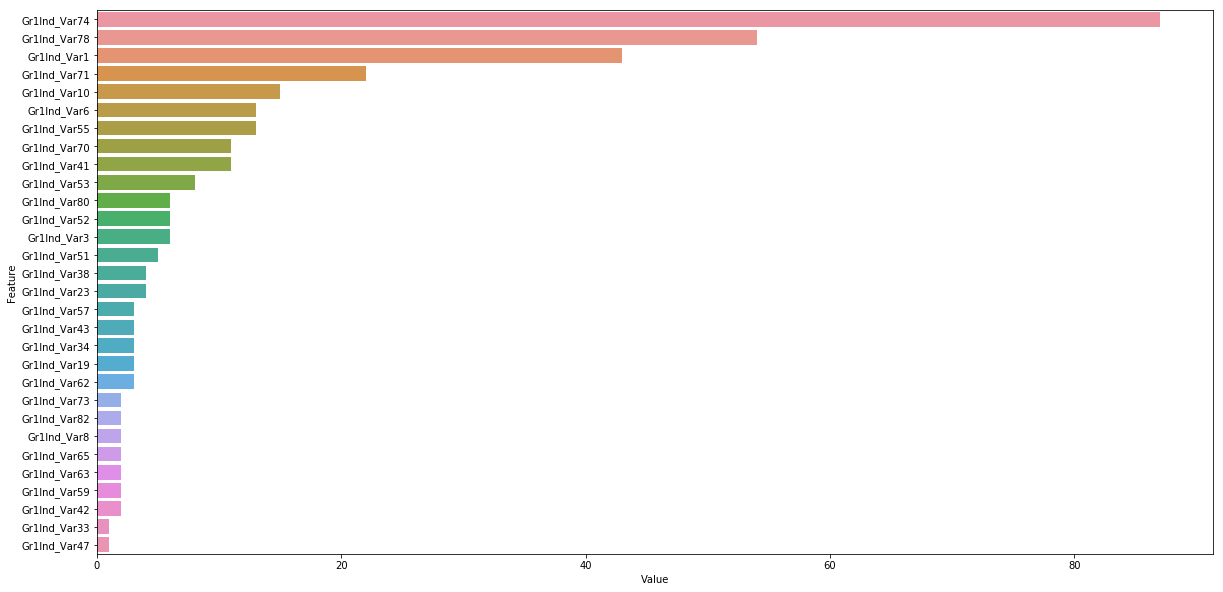

In [38]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:30])        
plt.show()

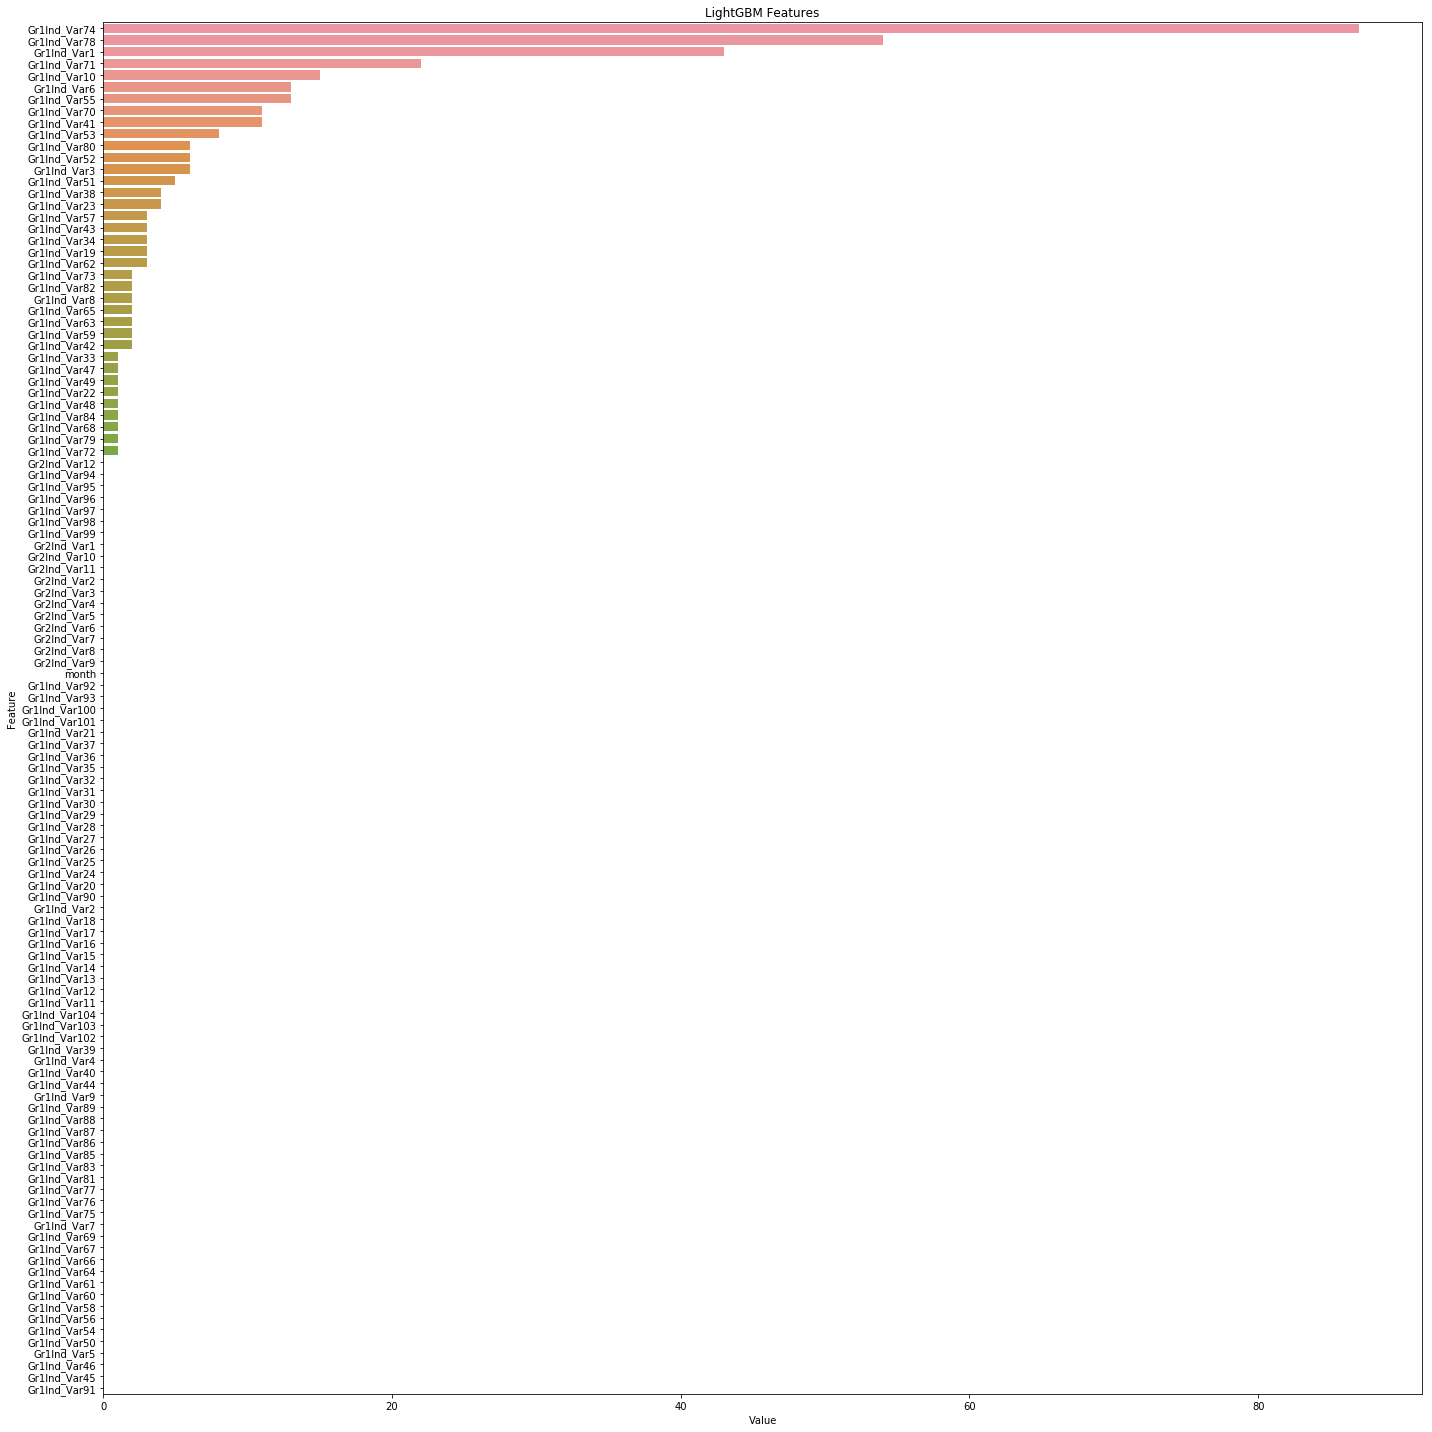

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(reg.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

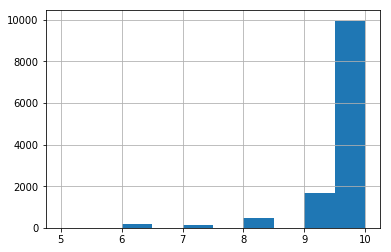

In [26]:
pd.Series(y_pred).hist()
plt.show()

## Fit same model to full training data and predict test data

In [27]:
bigger = len(df_train)/len(train)
full_nboost = int(nboost*bigger)
n_minus = int(n_minus*bigger)
n_plus = int(n_plus*bigger)
full_nboost

225

In [28]:
n_minus, n_plus

(52, 69)

In [29]:
full_X = df_train.drop(['Date', 'Identifier', 'Dep_Var'], axis=1)
full_y = df_train.Dep_Var
full_y_gauss = pd.Series(q.fit_transform(full_y.values.reshape(-1, 1)).reshape(-1))
d_full_train = lgb.Dataset(full_X.values.astype(np.float32), label=full_y_gauss)

params['max_depth'] = 2
full_reg = lgb.train(params, d_full_train, full_nboost)
test_pred_gauss = full_reg.predict(X_test)

params['max_depth'] = 3
full_reg = lgb.train(params, d_full_train, full_nboost-n_minus)
alpha = 0.5
test_pred_gauss = alpha*test_pred_gauss + (1-alpha)*full_reg.predict(X_test)

params['max_depth'] = 2
params['bagging_freq'] = 5
params['bagging_fraction'] = 0.78
params['learning_rate'] = .005
full_reg = lgb.train(params, d_full_train, full_nboost+n_plus)
alpha = 0.78
test_pred_gauss = alpha*test_pred_gauss + (1-alpha)*full_reg.predict(X_test)


test_pred_uniform = q.inverse_transform(test_pred_gauss.reshape(-1, 1)).reshape(-1)

In [30]:
test_pred = np.round(test_pred_uniform).astype(np.int)
test_pred[:20]

array([10, 10,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10,  9, 10])

In [31]:
test_pred.shape

(12626,)

In [32]:
output = df_test.copy()
output['Dep_Var'] = test_pred
output.head(20)

,Date,Identifier,Dep_Var,Gr1Ind_Var1,Gr1Ind_Var2,Gr1Ind_Var3,Gr1Ind_Var4,Gr1Ind_Var5,Gr1Ind_Var6,Gr1Ind_Var7,...,Gr2Ind_Var4,Gr2Ind_Var5,Gr2Ind_Var6,Gr2Ind_Var7,Gr2Ind_Var8,Gr2Ind_Var9,Gr2Ind_Var10,Gr2Ind_Var11,Gr2Ind_Var12,month
0,2015-10-23,39380,10,757.138424,1.011381,-0.016461,0.016145,0.015170,0.006936,0.128563,...,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.857143,0.000000,10
1,2015-10-23,27686,10,176.489196,0.984577,-0.041667,-0.105687,-0.104518,-0.123699,-1.297833,...,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.666667,0.000000,10
2,2015-10-23,130,9,1335.001430,1.067227,-0.005897,0.014202,-0.002536,0.030125,0.445860,...,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.666667,0.000000,10
3,2015-10-23,40130,10,154.685706,1.002754,-0.008748,0.000927,0.000868,0.005581,0.097687,...,0.0,0.083333,0.0,0.00,0.00,0.0,0.0,0.916667,0.076389,10
4,2015-10-23,30884,10,549.026934,1.079182,-0.032028,0.002453,0.002908,0.025576,0.407750,...,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.666667,0.000000,10
5,2015-10-23,38939,10,673.795354,0.956850,-0.014979,-0.015058,-0.017815,-0.009399,-0.146339,...,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.800000,0.000000,10
6,2015-10-23,24573,10,264.920318,0.863790,0.008840,0.035297,0.034840,0.035501,0.519390,...,0.0,0.200000,0.0,0.00,0.00,0.0,0.0,0.600000,0.120000,10
7,2015-10-23,6044,10,142504.289441,0.997806,-0.003572,-0.002046,-0.002214,0.000910,0.008319,...,2.0,0.200000,1.0,0.50,0.50,1.0,1.0,0.800000,0.160000,10
8,2015-10-23,45198,10,154.016592,1.791586,-0.134094,-0.018689,-0.020043,-0.055651,-0.130998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
9,2015-10-23,25670,10,1955.406432,1.158639,-0.025757,-0.004921,-0.009605,-0.012589,-0.097540,...,0.0,0.111111,0.0,0.00,0.00,0.0,0.0,0.777778,0.086420,10


In [33]:
output.tail()

,Date,Identifier,Dep_Var,Gr1Ind_Var1,Gr1Ind_Var2,Gr1Ind_Var3,Gr1Ind_Var4,Gr1Ind_Var5,Gr1Ind_Var6,Gr1Ind_Var7,...,Gr2Ind_Var4,Gr2Ind_Var5,Gr2Ind_Var6,Gr2Ind_Var7,Gr2Ind_Var8,Gr2Ind_Var9,Gr2Ind_Var10,Gr2Ind_Var11,Gr2Ind_Var12,month
12621,2016-07-22,13576,10,701.841292,0.951263,-0.047288,0.029570,0.028028,0.075557,0.330412,...,0.0,0.250000,0.0,0.000000,0.000000,0.0,0.0,0.500000,0.125000,7
12622,2016-07-22,26190,10,1920.466671,0.806523,-0.019754,0.008966,0.008899,0.012460,0.176963,...,1.0,0.333333,0.0,0.250000,0.250000,0.0,1.0,0.777778,0.259259,7
12623,2016-07-22,48466,10,3780.815789,0.897420,0.015751,0.007112,-0.002022,0.001428,0.041298,...,1.0,0.285714,0.0,0.200000,0.200000,0.0,1.0,0.857143,0.244898,7
12624,2016-07-22,49627,10,1201.424905,0.876473,0.016020,-0.068013,-0.068590,-0.097770,-0.601793,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.833333,0.000000,7
12625,2016-07-22,46066,9,678.295644,1.019832,-0.010667,-0.069850,-0.070993,-0.069453,-0.445771,...,1.0,0.111111,0.0,0.333333,0.333333,0.0,1.0,0.666667,0.074074,7


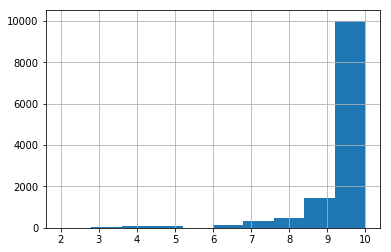

In [34]:
output.Dep_Var.hist()
plt.show()

In [35]:
output.to_csv('test_result.CSV')

In [40]:
feature_imp.sort_values(by="Value", ascending=False)['Feature'].values

array(['Gr1Ind_Var74', 'Gr1Ind_Var78', 'Gr1Ind_Var1', 'Gr1Ind_Var71',
       'Gr1Ind_Var10', 'Gr1Ind_Var6', 'Gr1Ind_Var55', 'Gr1Ind_Var70',
       'Gr1Ind_Var41', 'Gr1Ind_Var53', 'Gr1Ind_Var80', 'Gr1Ind_Var52',
       'Gr1Ind_Var3', 'Gr1Ind_Var51', 'Gr1Ind_Var38', 'Gr1Ind_Var23',
       'Gr1Ind_Var57', 'Gr1Ind_Var43', 'Gr1Ind_Var34', 'Gr1Ind_Var19',
       'Gr1Ind_Var62', 'Gr1Ind_Var73', 'Gr1Ind_Var82', 'Gr1Ind_Var8',
       'Gr1Ind_Var65', 'Gr1Ind_Var63', 'Gr1Ind_Var59', 'Gr1Ind_Var42',
       'Gr1Ind_Var33', 'Gr1Ind_Var47', 'Gr1Ind_Var49', 'Gr1Ind_Var22',
       'Gr1Ind_Var48', 'Gr1Ind_Var84', 'Gr1Ind_Var68', 'Gr1Ind_Var79',
       'Gr1Ind_Var72', 'Gr2Ind_Var12', 'Gr1Ind_Var94', 'Gr1Ind_Var95',
       'Gr1Ind_Var96', 'Gr1Ind_Var97', 'Gr1Ind_Var98', 'Gr1Ind_Var99',
       'Gr2Ind_Var1', 'Gr2Ind_Var10', 'Gr2Ind_Var11', 'Gr2Ind_Var2',
       'Gr2Ind_Var3', 'Gr2Ind_Var4', 'Gr2Ind_Var5', 'Gr2Ind_Var6',
       'Gr2Ind_Var7', 'Gr2Ind_Var8', 'Gr2Ind_Var9', 'month',
       'Gr1Ind_Var92', 'Gr